# EDA on Argentine lakes and reservoirs dataset

*Short description: EDA on dataset of 103 argentine lake and reservoir data from Argentina. Dataset adapted from paper by R. Quirós (1988)*

## Table of Contents

1. [Description of the problem](#description-of-the-problem)
2. [Preliminary steps](#prelimnary-steps) 
3. [Understanding the data](#understanding-the-data)
4. [Feature Engineering](#feature-engineering)
5. [Variation correlation](#variable-correlation)

![lacar](lacar.jpg)

## Description of the problem <a class="anchor" id="description"></a>

Small dataset that includes morphometric, climatic, nutrient levels and chlorofill values and from 103 argentine lakes and reservoirs.

### Research objective:

>*Analyze the influence of different variables regarding the eutrophication of lakes and reservoirs in Argentina*


## Prelimnary steps <a class="anchor" id="prelim"></a>

First of all, we import the libraries that will be using during this analysis and load the dataset into the **data** variable:

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from plotly.io import write_image

filepath = "./lake_res_data.csv"
data = pd.read_csv(filepath)
data = data.drop(columns='ID')
data = data.set_index('NAME')

## Understanding the data <a class="anchor" id="understanding"></a>
Next, we will explore some characteristics of the dataset using relevant pandas methods such as **info()**, **describe()** and **head()**:

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, Rodeo to Ameghino
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TYPE    103 non-null    object 
 1   REGION  103 non-null    object 
 2   AREA    103 non-null    float64
 3   ZMEAN   103 non-null    float64
 4   ALT     103 non-null    int64  
 5   LAT     103 non-null    float64
 6   TEMP    103 non-null    float64
 7   SDT     103 non-null    float64
 8   TP      103 non-null    int64  
 9   TON     103 non-null    int64  
 10  CHL-a   103 non-null    float64
dtypes: float64(6), int64(3), object(2)
memory usage: 9.7+ KB


In [103]:
print(f"Unique values for 'TYPE' column: {data['TYPE'].unique().tolist()}")
print(f"Unique values for 'REGION' column: {data['REGION'].unique().tolist()}")

Unique values for 'TYPE' column: ['lake', 'reservoir']
Unique values for 'REGION' column: ['ANW', 'Pampas Mountains', 'Cuyo', 'Pampa Plain', 'Patagonian Plateau', 'Patagonian Andes']


In [104]:
data['TYPE'].value_counts()

TYPE
lake         73
reservoir    30
Name: count, dtype: int64

In [105]:
data['REGION'].value_counts()

REGION
Patagonian Andes      39
Pampa Plain           26
ANW                   11
Pampas Mountains      10
Patagonian Plateau     9
Cuyo                   8
Name: count, dtype: int64

In [106]:
data.describe()

,AREA,ZMEAN,ALT,LAT,TEMP,SDT,TP,TON,CHL-a
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,73.370000,25.610680,583.776699,37.202718,11.866019,4.322718,221.854369,100.368932,25.772621
std,234.395916,36.272095,481.896192,5.603130,5.239585,4.940594,823.340713,125.403427,54.056045
min,0.090000,0.700000,2.000000,24.120000,3.000000,0.030000,1.000000,6.000000,0.160000
25%,4.350000,3.100000,159.500000,34.375000,6.000000,0.675000,9.000000,21.000000,0.830000
50%,12.000000,8.100000,550.000000,37.880000,14.000000,2.000000,30.000000,45.000000,6.700000
75%,44.300000,33.150000,844.500000,42.310000,16.000000,7.250000,125.500000,126.000000,23.750000
max,1984.000000,166.000000,3250.000000,45.900000,20.400000,19.000000,7912.000000,762.000000,405.300000


In [107]:
data.sample(5)

,TYPE,REGION,AREA,ZMEAN,ALT,LAT,TEMP,SDT,TP,TON,CHL-a
NAME,,,,,,,,,,,
Lezama,lake,Patagonian Andes,7.5,36.0,750,42.45,6.0,16.0,4,20,0.74
Río Hondo,reservoir,ANW,330.0,5.3,275,27.50,20.0,0.4,322,61,10.40
Steffen,lake,Patagonian Andes,6.3,46.7,525,41.52,6.0,13.0,3,13,0.21
Pico 3,lake,Patagonian Andes,4.5,3.8,550,44.20,5.0,3.2,33,41,2.80
Epecuén,lake,Pampa Plain,45.0,4.0,95,37.13,15.0,0.2,1608,316,55.40


As we can see, the data is structured in an index and 11 fields. The meaning of each column is described below:
+ **NAME (index)**: Name of the waterbody.
+ **TYPE**: Type of the waterbody.
+ **REGION**: Geographical region where the waterbody is lcoated.
+ **AREA**: Area, in $km^2$.
+ **ZMEAN**: Mean depth, in $m$.
+ **ALT**: Elevation, in $m$.
+ **LAT**: Latitude, $°S$.
+ **TEMP**: Annual mean air temperature, in $°C$.
+ **SDT**: Secchi disk transparency, in $m$.
+ **TP**: Total phosphorus, in $mg.m^{-3}$.
+ **TON**: Total organic nitrogen, in $\mu.M$
+ **CHL-a**: Total chlorophyll-a, in $mg.m^{-3}$.

# Feature Engineering <a class="anchor" id="feature"></a>
I will create some other variables that may be useful for our analysis:

In [108]:
data['VOL'] = data['AREA'] * data['ZMEAN']
data['DEPTH'] = np.where((data['ZMEAN'] > 5), 'deep', 'shallow')

Now, I'll create columns for the three Carlson's Trophic State Index (TSI), as proposed by Carlson (1977):

$TSI_{SD} = 60 - 14.41 {\ln}(SD)$

$TSI_{TP} = 4.15 + 14.42 {\ln}(TP)$

$TSI_{CHL-a} = 30.6 + 9.81 {\ln}(CHL-a)$

In [109]:
data['TSI-SD'] = 60 - 14.41*np.log(data['SDT'])
data['TSI-TP'] = 4.15 + 14.42*np.log(data['TP'])
data['TSI-CHL-a'] = 30.6 + 9.81*np.log(data['CHL-a'])

In [110]:
data.describe()

,AREA,ZMEAN,ALT,LAT,TEMP,SDT,TP,TON,CHL-a,VOL,TSI-SD,TSI-TP,TSI-CHL-a
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,73.370000,25.610680,583.776699,37.202718,11.866019,4.322718,221.854369,100.368932,25.772621,2474.747515,51.153562,56.114056,46.743910
std,234.395916,36.272095,481.896192,5.603130,5.239585,4.940594,823.340713,125.403427,54.056045,9450.337687,21.308156,26.212035,19.383983
min,0.090000,0.700000,2.000000,24.120000,3.000000,0.030000,1.000000,6.000000,0.160000,0.324000,17.570634,4.150000,12.622376
25%,4.350000,3.100000,159.500000,34.375000,6.000000,0.675000,9.000000,21.000000,0.830000,14.295000,31.462341,35.833978,28.714093
50%,12.000000,8.100000,550.000000,37.880000,14.000000,2.000000,30.000000,45.000000,6.700000,109.340000,50.011749,53.195266,49.259675
75%,44.300000,33.150000,844.500000,42.310000,16.000000,7.250000,125.500000,126.000000,23.750000,625.145000,65.673634,73.830819,61.673963
max,1984.000000,166.000000,3250.000000,45.900000,20.400000,19.000000,7912.000000,762.000000,405.300000,87449.000000,110.529499,133.585879,89.505396


## Variable correlation <a class="anchor" id="correlation"></a>

Using a correlation matrix, will check how each variable correlates to each other

<Axes: >

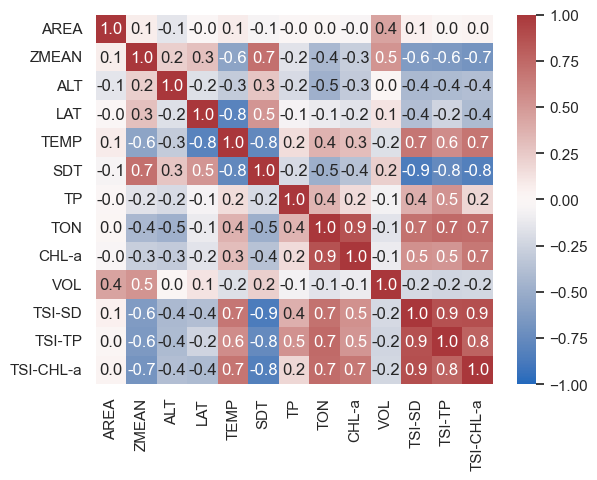

In [111]:
sns.set(style='white')
corr = data.drop(columns=['TYPE', 'REGION', 'DEPTH']).corr()
sns.heatmap(corr,cmap='vlag',vmin=-1, vmax=1, fmt='.1f', annot=True)

Looking at the correlation matrix, we can see some interesting things:

1. All TSI are strongly correlated to one another.
2. Total Organic Nitrogen is positively correlated to al TSI.
3. Total Organic Nitrogen is strongly correlated to Chlorophyll-a.
4. Temperature is strongly correlated to all three TSI.
5. Total Phosphorus dues not have strong correlation with any variable, except it's corresponding TSI.
6. Area of the lake does not correaltes with any TSI.
7. Mean depth is more correlated to TSI than volume.

## Univariable Analysis

In [112]:
def apply_custom_layout(figure,
                        figure_title,
                        xaxis_title,
                        yaxis_title,
                        width=None,
                        height=None,
                        show_legend=True,
                        legend_title='Legend',
                        font='Garamond',
                        bg_color='#FFFFFF',
                        axis_color='#BCCCDC',
                        grid_color='#BCCCDC',
                        spike_color='#999999',
                        title_fontsize=20,
                        legend_fontsize=16,
                        axis_fontsize=18,
                        tick_fontsize=14,
                        show_major_xgrid=True,
                        display_minor_xaxis=True,
                        dtick_xaxis='M3',
                        show_minor_xgrid=True,
                        show_major_ygrid=False,
                        show_xspikes=True):
    """Applies desired custom formatting to figure layout.

    Parameters
    ----------
    figure : plotly.graph_objects.Figure instance
        Figure whose layout will be updated
    figure_title : str
        Desired figure title
    xaxis_title : str
        Desired X-axis title
    yaxis_title : str
        Desired Y-axis title
    width : int, optional
        Figure width, in number of px, by default None. If both widht and height
        are None, figure will autosize.
    height : int, optional
        Figure height, in number of px, by default None. If both widht & height
        are None, figure will autosize.
    show_legend : bool, optional
        Determines if legend will be printed, by default 'True'.
    legend_title : str, optional
        Legend title, by default 'Legend'. If legend_title=None, no title will
        be printed.
    font : str, optional
        Font to be used on title, axis, ticks and legend, by default 'Garamond'
    bg_color : str, optional
        Background color, by default '#FFFFFF'
    axis_color : str, optional
        Axis (not axis title) color, by default '#BCCCDC'
    grid_color : str, optional
        Grid color, by default '#BCCCDC'
    spike_color : str, optional
        Spike color, by default '#999999'
    title_fontsize : int, optional
        Title fontsize, by default 20
    legend_fontsize : int, optional
        Legend fontsize, by default 16
    axis_fontsize : int, optional
        Axis title fontsize, by default 18
    tick_fontsize : int, optional
        Tick fontsize, by default 14
    show_major_xgrid : bool, optional
        If True displays grid on major ticks for X-axis, by default True
    display_minor_xaxis : bool, optional
        If True displays grid on minor ticks for X-axis, by default True
    dtick_xaxis : str, optional
        Minor X-axis ticks steps, by default 'M3'
        The default 'M3' means minor ticks every three months. For more info go
        to: https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-dtick
    show_minor_xgrid : bool, optional
        If True displays grid on major ticks for X-axis, by default True
    show_major_ygrid : bool, optional
        If True displays grid on major ticks for Y-axis, by default False
    show_xspikes : bool, optional
        If True displays spikes on hover for X-axis, by default True
    """
    # Updates the layout of the figure
    figure.update_layout(
        font_family=font,  # Font to be used in all elements, unless overridden
        plot_bgcolor=bg_color,  # Background color
        title_text=figure_title,  # Title text
        title_font_size=title_fontsize,  # Title fontsize
        autosize=bool((width is None) and (height is None)),
        width=width,
        height=height,
        showlegend=show_legend,
        legend={  # Places legend horizontally, top right of the graph
            'title': legend_title,
            'font_size': legend_fontsize,  # Legend fontsize
            'orientation': 'h',
            'yanchor': 'bottom',
            'y': 1.02,
            'xanchor': 'right',
            'x': 1
        },
        hovermode='x',
        hoverdistance=1,  # Distance to show hover label of data point
        spikedistance=1000,  # Distance to show spike
        xaxis={
            'title': xaxis_title,  # Text to display in X-axis
            'title_font_size': axis_fontsize,  # X-axis fontsize
            'linecolor': axis_color,  # Color of X-axis (not X-axis text)
            'showgrid': show_major_xgrid,  # Show grid of X-axis major ticks
            'gridcolor': grid_color,  # Color of major X-axis grid
            'tickfont_size': tick_fontsize,  # Fontsize for X-axis ticks
            'minor': {
                'dtick': dtick_xaxis,  # Distance of minor X-axis ticks
                'ticks': 'inside',  # X-axis minor ticks in or out from axis
                'showgrid': show_minor_xgrid  # Show grid of X-axis minor ticks
            } if display_minor_xaxis is True else None,
            'showspikes': show_xspikes,  # Show spike line for X-axis
            # Format spike
            'spikethickness': 2,
            'spikedash': 'dot',  # Spike linetype
            'spikecolor': spike_color,  # Spike color
            'spikemode': 'across'
        },
        yaxis={
            'title': yaxis_title,  # Text to display in Y-axis
            'title_font_size': axis_fontsize,  # Y-axis fontsize
            'linecolor': axis_color,  # Color of Y-axis (not Y-axis text)
            'showgrid': show_major_ygrid,  # Show grid of Y-axis major ticks
            'gridcolor': grid_color,  # Color of major Y-axis grid
            'tickfont_size': tick_fontsize,  # Fontsize for Y-axis ticks
        })

In [135]:
fig = px.histogram(data, x="SDT", color="TYPE", marginal="violin", # can be `box`, `violin`
)
fig.show()

In [ ]:
fig3 = px.scatter(data_frame=data,
x='TON',
y='CHL-a',
log_x=True,
log_y=True,
trendline='ols',
trendline_options=dict(log_x=True, log_y=True),
color='TYPE',
hover_name=data.index,
)
fig_title = 'Differences Between lakes and Reservoirs in TON/CHL-a Relationship'
xaxis_title='Total Organic Nitrogen [μM]'
yaxis_title='Chlorophyll-a [mg.m<sup>-3</sup>]'

apply_custom_layout(fig3, fig_title, xaxis_title, yaxis_title, font='Lora', show_xspikes=True, legend_title=None)
fig3.update_layout(hovermode='closest',  coloraxis_colorbar_orientation='h')
fig3.show()

In [ ]:
fig1 = px.violin(data_frame=data, x='DEPTH', y='TSIc-CHL-a', color='DEPTH', color_discrete_sequence=px.colors.qualitative.Bold ,box=True, points='all', hover_name=data.index, labels={
                     'LAT': 'Latitude [°]',
                     'SDT': 'Secchi Disk Transparency [m]',
                     'ZMEAN': 'Mean Depth [m]',
                     'ALT': 'Altitude'
                 })
fig_title = 'Distribution of TSI-CHL-a in Argentina\'s Different Geographic Regions'
yaxis_title='TSI-CHL-a'

apply_custom_layout(fig1, fig_title, None, yaxis_title, font='Lora', show_xspikes=False, show_legend=False)
fig1.show()


In [ ]:
fig = px.scatter_3d(data_frame=data, x='TSIc-SD', y='TSIc-TP', z='TSIc-CHL-a', color='REGION', hover_name=data.index, title='Three TSI in Argentina\'s Different Geographic Regions')
fig.update_layout(font_family='Garamond',  # Font to be used in all elements, unless overridden
        plot_bgcolor='#FFFFFF',
        legend_title='Regions',
        width=850,
        height=900,
        title_font_size=18,  # Title fontsize
        xaxis={
            'linecolor': '#BCCCDC',  # Color of X-axis (not X-axis text)
            'gridcolor': '#BCCCDC'},  # Color of major X-axis grid
        yaxis={
            'linecolor': '#BCCCDC',  # Color of X-axis (not X-axis text)
            'gridcolor': '#BCCCDC'})  # Color of major X-axis grid

fig.show()

In [ ]:
aux_df = data
aux_df['TSI-CHL-a - TSI-SD'] = data['TSIc-CHL-a'] - data['TSIc-SD']
aux_df['TSI-CHL-a - TSI-TP'] = data['TSIc-CHL-a'] - data['TSIc-TP']

In [ ]:
fig1 = px.scatter(data_frame=aux_df, x='TSI-CHL-a - TSI-SD', y='TSI-CHL-a - TSI-TP', color='REGION', hover_name= data.index, title = 'Relationship between TSI')

fig_title = 'Relationship between different TSI throughout Argentina\'s Different Geographic Regions'
xaxis_title='TSI-CHL-a - TSI-SD'
yaxis_title='TSI-CHL-a - TSI-TP'

apply_custom_layout(fig1, fig_title, xaxis_title, yaxis_title, font='Lora', show_xspikes=False, legend_title=None)
fig1.update_layout(hovermode='closest',  coloraxis_colorbar_orientation='h')
fig1.add_vline(0)
fig1.add_hline(0)
fig1.show()
